In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

model_ckpt = './affectnet-supcon/'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)
model = ViTForImageClassification.from_pretrained(model_ckpt).to(device)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

In [10]:
from torchaffectnet.datasets import AffectNetDatasetForSupCon

class AffectNetDatasetForSupConWithValence(AffectNetDatasetForSupCon):
    def labeling(self, idx):
        target = torch.tensor(self.df['valence'][idx])
        if target < -0.5:
            return torch.tensor(0)
        elif target > 0.5:
            return torch.tensor(2)
        else:
            return torch.tensor(1)

In [11]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize
])

val_contrastive_dataset = AffectNetDatasetForSupConWithValence('../Affectnet/validation.csv',
                                                    images_root,
                                                    transform=transform)
len(val_contrastive_dataset)

4500

In [12]:
from tqdm import tqdm

def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

In [13]:
from umap.umap_ import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, labels, n_neighbors, id2label):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='right')
    plt.show()

In [14]:
labeled_valence = {
    0: 'valence < -0.5',
    1: '-0.5 <= valence <= 0.5',
    2: '0.5 < valence',
}

100%|██████████| 4500/4500 [00:58<00:00, 77.48it/s] 


(4500, 2)
(4500,)


/tmp/ipykernel_29034/436394922.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


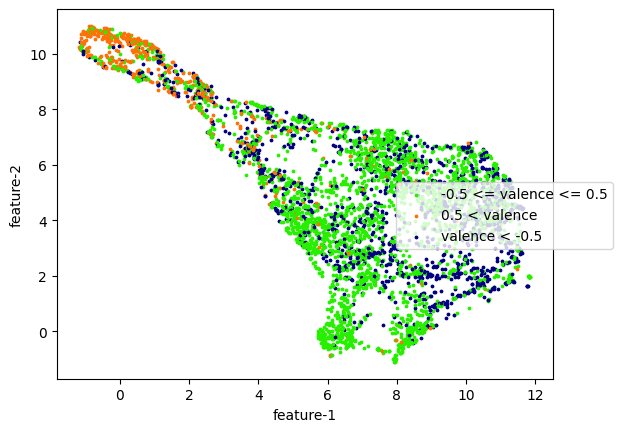

In [15]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_contrastive_dataset,
                            device)
plot_tokens(tokens, labels, 10, labeled_valence)